<a name="software-requirements"></a>
# Software Requirements

In [ ]:
%%bash
python -m pip install --upgrade pip
pip install git+https://github.com/aditya-grover/climate-learn.git@tutorials-split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="temporal-forecasting"></a>
# Temporal Forecasting

## Data Preparation

Check out the [Data Processing Notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Data_Processing) for more info on this part.

In [ ]:
from climate_learn.utils.data import load_dataset
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import ForecastingArgs
from climate_learn.data import download, DataModuleArgs, DataModule

# Download data from weatherbench (~2-3 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")
dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/2m_temperature")

data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

forecasting_args = ForecastingArgs(
    dataset_args = data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    pred_range = 3*24,
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = forecasting_args,
    train_start_year = 1979,
    val_start_year = 2015,
    test_start_year = 2017,
    end_year = 2018,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:00<00:00, 74.13it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 68.64it/s]


Creating test dataset


100%|██████████| 3/3 [00:00<00:00, 61.67it/s]


## Model Training & Evaluation

Check out the [Model notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Model_Training_&_Evaluation) for more info.

In [ ]:
from climate_learn.models import load_model
from climate_learn.models import set_climatology
from climate_learn.models import fit_lin_reg_baseline

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

set_climatology(model_module, data_module)
fit_lin_reg_baseline(model_module, data_module, reg_hparam=0.0)

### Training & Evaluation


In [ ]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

trainer.fit(model_module, data_module)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

In [ ]:
trainer.test(model_module, data_module)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205/205 0:00:45 • 0:00:00 4.40it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             test/acc_2m_temperature_day_3              │                   0.817751106190026                    │
│            test/w_rmse_2m_temperature_day_3            │                   3.054664949808956                    │
│ test_climatology_baseline/w_rmse_2m_temperature_day_3  │                   5.859798067678751                    │
│ test_persistence_baseline/w_rmse_2m_temperature_day_3  │                   3.2076813060154206                   │
│ test_ridge_regression_baseline/w_rmse_2m_temperature_… │                   3.2930732518237598                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

Visualization is done on the test set. We can either specify exact time for the initial condition, or randomly sample from the test set.

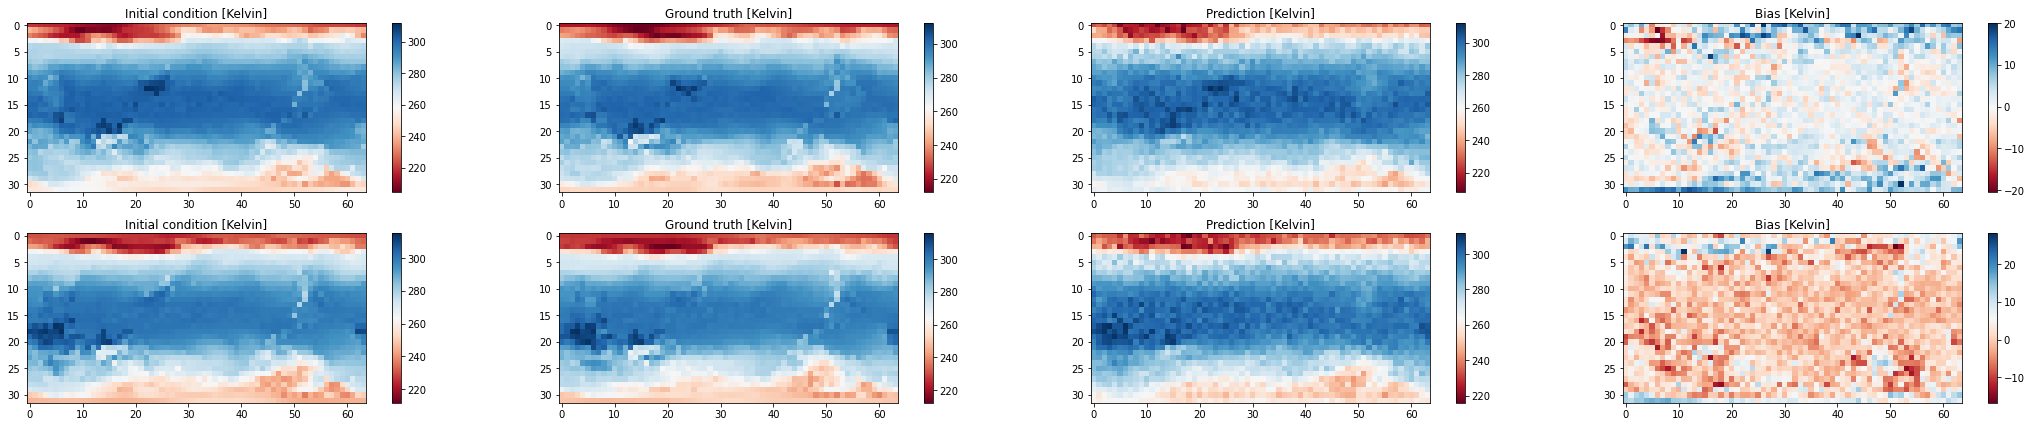

In [ ]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])

In addition to visualizing the bias the model makes for each individual data point, we can also visualize the mean bias across the entire test set.

100%|██████████| 205/205 [00:58<00:00,  3.50it/s]


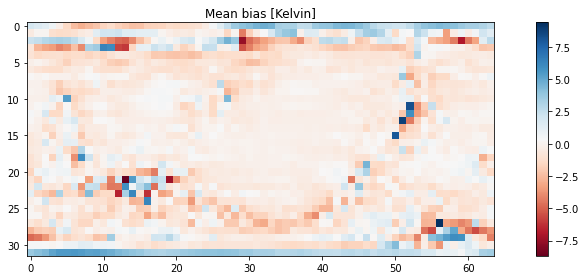

In [ ]:
from climate_learn.utils import visualize_mean_bias
visualize_mean_bias(model_module.cuda(), data_module)

<a name="spatial-downscaling"></a>
# Spatial Downscaling

## Data Preparation

In [ ]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import DownscalingArgs
from climate_learn.data import download, DataModuleArgs, DataModule

# Download data from weatherbench (~4-6 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "2.8125")

lowres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

highres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/2.8125",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

downscaling_args = DownscalingArgs(
    dataset_args = data_args,
    highres_dataset_args = highres_data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = downscaling_args,
    train_start_year = 1979,
    val_start_year = 2015,
    test_start_year = 2017,
    end_year = 2018,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Creating val dataset


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Creating test dataset


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


## Model Training & Evaluation 

In [ ]:
from climate_learn.models import load_model
from climate_learn.models import set_climatology
from torch.optim import AdamW

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": AdamW,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

set_climatology(model_module, data_module)

### Training & Evaluation


In [ ]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24/24 0:00:19 • 0:00:00 1.24it/s loss: 0.0616 train/2m_temperature:  
                                                                               0.057 train/loss: 0.057             

In [ ]:
trainer.test(model_module, data_module)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35/35 0:00:15 • 0:00:00 2.24it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias_2m_temperature │      -0.7963107824325562      │
│ test/pearsonr_2m_temperature  │      0.9912776310847699       │
│   test/rmse_2m_temperature    │      2.8612732887268066       │
└───────────────────────────────┴───────────────────────────────┘

## Visualization 

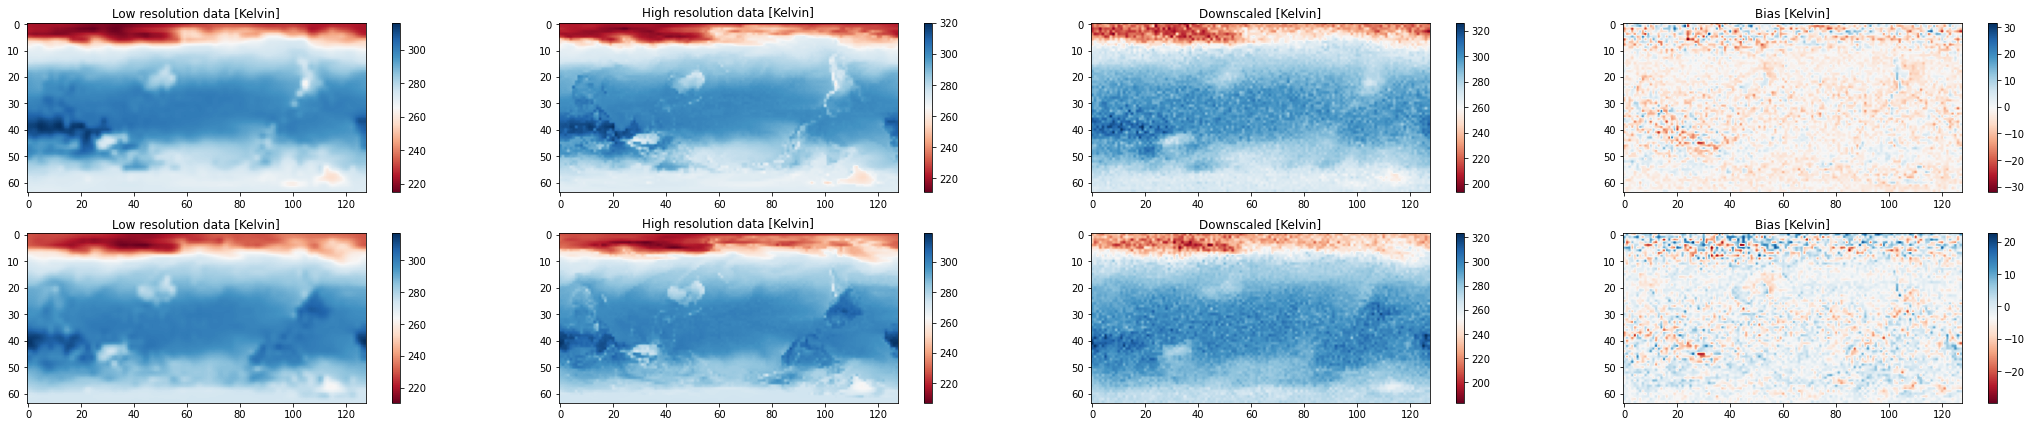

In [ ]:
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])